# Dependencies

In [1]:
!pip install pytorch-ignite -q

import PIL
import numpy as np
import sys
import random
import torch
from torch.nn.functional import interpolate
from torchvision import transforms
from torchvision.transforms import functional as ttf
import numbers
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
from mrunet import *
from zssrnet import *
from swinir import *

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.metrics.regression import *
from ignite.utils import *
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 9.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
class RandomRotationFromSequence(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        self.degrees = degrees
        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.choice(degrees)
        return angle

    def __call__(self, data):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        hr, lr = data
        angle = self.get_params(self.degrees)
        return ttf.rotate(hr, angle, self.resample, self.expand, self.center), \
                ttf.rotate(lr, angle, self.resample, self.expand, self.center)

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.hflip(hr), ttf.hflip(lr)
        return hr, lr

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.vflip(hr), ttf.vflip(lr)
        return hr, lr

class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(data, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        hr, lr = data
        w, h = hr.size
        th, tw = output_size
        if w == tw or h == th:
            return 0, 0, h, w

        if w < tw or h < th:
            th, tw = h//2, w//2

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        hr, lr = data
        if self.padding > 0:
            hr = ttf.pad(hr, self.padding)
            lr = ttf.pad(lr, self.padding)

        i, j, h, w = self.get_params(data, self.size)
        return ttf.crop(hr, i, j, h, w), ttf.crop(lr, i, j, h, w)

class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, data):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        hr, lr = data
        return ttf.to_tensor(hr), ttf.to_tensor(lr)

# General Utils
def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

# Evaluation metrics
def eval_step(engine, batch):
    return batch
evaluator = Engine(eval_step)

class CustomSSIM:
    """SSIM stimated by torch.ignite"""
    def __init__(self, evaluator):
        self.name="SSIM"
        self.evaluator = evaluator
        self.metric = SSIM(data_range=1.0)
        self.metric.attach(self.evaluator, "ssim")
    def __call__(self, lr, hr):
        state = self.evaluator.run([[lr, hr]])
        return self.metrics["ssim"]

class PSNR: #### check out img range for grayscale [0,1]
    """Peak Signal to Noise Ratio"""
    def __init__(self):
        self.name = "PSNR"
    @staticmethod
    def __call__(img1, img2):
        mse = torch.mean((img1 - img2) ** 2)
        return (20 * torch.log10(255.0 / torch.sqrt(mse))).item()

psnr = PSNR()
ssim = CustomSSIM(evaluator)

# Orirginal Implementation

In [5]:
class DataSampler:
    def __init__(self, img, sr_factor, crop_size):
        self.img = img
        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        sizes = np.float32([x[0].size[0]*x[0].size[1] / float(img.size[0]*img.size[1]) \
            for x in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            RandomRotationFromSequence([0., 90., 180., 270.]),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomCrop((crop_size, crop_size)),
            ToTensor()])

    def create_hr_lr_pairs(self):
        smaller_side = min(self.img.size[0 : 2])
        larger_side = max(self.img.size[0 : 2])

        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = self.img.resize((int(self.img.size[0]*zoom), \
                                int(self.img.size[1]*zoom)), \
                resample=PIL.Image.BICUBIC)

            lr = hr.resize((int(hr.size[0]/self.sr_factor), \
                int(hr.size[1]/self.sr_factor)),
                resample=PIL.Image.BICUBIC)

            lr = lr.resize(hr.size, resample=PIL.Image.BICUBIC)

            pairs.append((hr, lr))

        return pairs

    def generate_data(self):
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            hr_tensor, lr_tensor = self.transform((hr, lr))
            hr_tensor = torch.unsqueeze(hr_tensor, 0)
            lr_tensor = torch.unsqueeze(lr_tensor, 0)
            yield hr_tensor, lr_tensor


UP_SCALE = 4
PATCH_SIZE = 64

img = PIL.Image.open("alligator.jpg").resize((200,200))
sampler = DataSampler(img,
                    sr_factor=UP_SCALE,
                    crop_size=PATCH_SIZE)


In [ ]:
for hr, lr in sampler.pairs:
    _, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(hr)
    axs[1].imshow(lr)
    plt.show()

### Self-supervised training

 33%|███▎      | 5011/15000 [00:40<01:20, 124.50it/s, Iteration: 5023/15000 lr: 1.0000000000000002e-06 Loss « 0.0453559905 »]


Learning rate reduced to 1.0000000000000002e-06


 67%|██████▋   | 10021/15000 [01:20<00:44, 111.84it/s, Iteration: 10023/15000 lr: 1.0000000000000002e-07 Loss « 0.0540202856 »]


Learning rate reduced to 1.0000000000000002e-07


100%|██████████| 15000/15000 [02:06<00:00, 118.50it/s, Iteration: 14999/15000 lr: 1.0000000000000002e-07 Loss « 0.0596431047 »]


Done training.


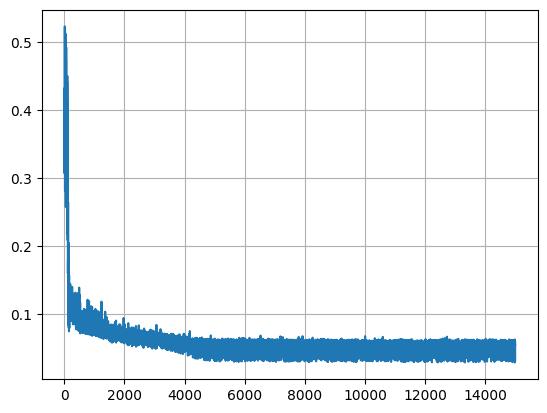

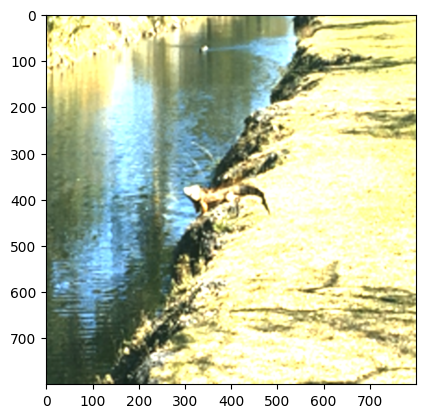

In [15]:
from torch.autograd import Variable
from tqdm import tqdm

UP_SCALE = 4
PATCH_SIZE = 128
BATCH_SIZE = 8


def train(model, img, sr_factor=4, num_batches=10000, learning_rate=0.0001,
          crop_size=64):

    # Model specs initialization
    loss = torch.nn.L1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    sampler = DataSampler(img, sr_factor, crop_size)

    model.train()
    progress_bar = tqdm(range(num_batches), total=num_batches)
    cache = torch.zeros(num_batches)
    for iteration in progress_bar:
        hr, lr = sampler.generate_data().__next__()

        lr = lr.cuda()
        hr = hr.cuda()

        # Residual mapping (if not implemented by default)
        output = model(lr) # + lr
        error = loss(output, hr)

        if iteration > 0 and iteration % 5000 == 0:
            learning_rate = learning_rate / 10
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

        progress_bar.set_postfix_str(f"Iteration: {iteration}/{num_batches} lr: {learning_rate} Loss « {(error.item()):.10f} »")

        error.backward()
        optimizer.step()
        optimizer.zero_grad()

        cache[iteration] = error.item()

    print("Done training.")
    return cache


def test(model, img, sr_factor):
    model.eval()

    img = img.resize((int(img.size[0]*sr_factor), \
        int(img.size[1]*sr_factor)), resample=PIL.Image.BICUBIC)

    with torch.no_grad():
        img = transforms.ToTensor()(img)
        img = torch.unsqueeze(img, 0)
        input = Variable(img.to(DEVICE))
        residual = model(input)
        output = input + residual

    output = output.cpu().data[0, :, :, :]
    o = output.numpy()
    o[np.where(o < 0)] = 0.0
    o[np.where(o > 1)] = 1.0
    output = torch.from_numpy(o)
    output = transforms.ToPILImage()(output)
    return output

if __name__=="__main__":

    UP_SCALE = 4
    NUM_ITER = 15000
    LEARN_RATE = 1e-5
    CROP_SIZE = 200
    img = PIL.Image.open("alligator.jpg").resize((200,200))

    model = ZSSRNet(input_channels=3, kernel_size=3, channels=64, ndepth=6).to(DEVICE)
    history = train(model, img, sr_factor=UP_SCALE, num_batches=NUM_ITER, learning_rate=LEARN_RATE,
          crop_size=CROP_SIZE)
    srimg = test(model, img, sr_factor=UP_SCALE)

    plt.plot(history)
    plt.grid(); plt.show()


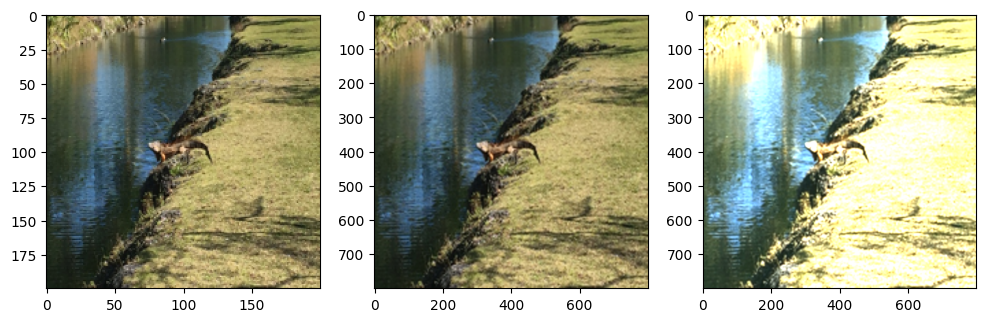

In [24]:
_,axs = plt.subplots(1,3,figsize=(12, 8))
axs[0].imshow(img)
axs[1].imshow(img.resize((img.size[0]*UP_SCALE, img.size[1]*UP_SCALE), resample=PIL.Image.BICUBIC))
axs[2].imshow(srimg)
plt.show()

# Custom implementation

In [10]:
class DataSampler:
    def __init__(self, img, sr_factor, crop_size, batch_size=8, nchannels=3):
        self.img = img
        self.nchannels = nchannels
        self.crop_size = crop_size
        self.sr_factor = sr_factor
        self.batch_size = batch_size
        self.pairs = self.create_hr_lr_pairs()
        sizes = np.float32([x[0].size[0]*x[0].size[1] / float(img.size[0]*img.size[1]) \
            for x in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            RandomRotationFromSequence([0., 90., 180., 270.]),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            RandomCrop((crop_size, crop_size)),
            ToTensor()])

        self.resize = transforms.Resize(size = (crop_size, crop_size))

    def create_hr_lr_pairs(self):
        smaller_side = min(self.img.size[0 : 2])
        larger_side = max(self.img.size[0 : 2])

        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = self.img.resize((int(self.img.size[0]*zoom), \
                                int(self.img.size[1]*zoom)), \
                resample=PIL.Image.BICUBIC)

            lr = hr.resize((int(hr.size[0]/self.sr_factor), \
                int(hr.size[1]/self.sr_factor)),
                resample=PIL.Image.BICUBIC)

            lr = lr.resize(hr.size, resample=PIL.Image.BICUBIC)

            pairs.append((hr, lr))

        return pairs

    def sample_pair(self):
        """ Return a single {hr-lr} pair
        """
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            hr_tensor, lr_tensor = self.transform((hr, lr))
            hr_tensor = torch.unsqueeze(hr_tensor, 0)
            lr_tensor = torch.unsqueeze(lr_tensor, 0)
            yield hr_tensor, lr_tensor

    def check_dimension(self, tensor):
        """ Ensuring sub-patches to repsect crop size dimension
        """
        c, h, w = (self.nchannels, self.crop_size, self.crop_size)
        if tensor.shape != (c, h, w):
           tensor = self.resize(tensor)
        return tensor

    def generate_data(self):
        """ Yield a batch of {hr-lr} pairs
        Return
            hr: torch.Tensor of dim: (batch_size, n_channels, H, W)
            lr: torch.Tensor of dim: (batch_size, n_channels, H, W)
        """
        while True:
            batch = random.choices(self.pairs, weights=self.pair_probabilities, k=self.batch_size)
            batch = [self.transform((hr, lr)) for hr, lr in batch]
            hr_tensor = torch.cat([self.check_dimension(hr).unsqueeze(0) for hr, _ in batch], 0)
            lr_tensor = torch.cat([self.check_dimension(lr).unsqueeze(0) for _, lr in batch], 0)
            yield hr_tensor, lr_tensor

UP_SCALE = 4
PATCH_SIZE = 50
BATCH_SIZE = 8

img = PIL.Image.open("alligator.jpg")
sampler = DataSampler(img,
                        sr_factor=UP_SCALE,
                        crop_size=PATCH_SIZE,
                      batch_size=BATCH_SIZE)

# Perform Self-supervised training

In [ ]:
smaller_side = 200
larger_side = 200
sr_factor = 4


(40, 40) (40, 40)
(50, 50) (50, 50)
(60, 60) (60, 60)
(70, 70) (70, 70)
(80, 80) (80, 80)
(90, 90) (90, 90)
(100, 100) (100, 100)
(110, 110) (110, 110)
(120, 120) (120, 120)
(130, 130) (130, 130)
(140, 140) (140, 140)
(150, 150) (150, 150)
(160, 160) (160, 160)
(170, 170) (170, 170)
(180, 180) (180, 180)
(190, 190) (190, 190)
(200, 200) (200, 200)


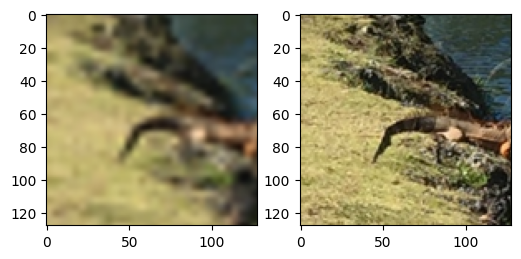

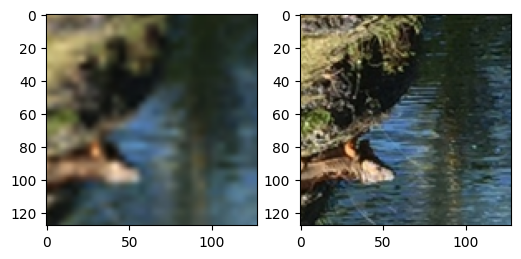

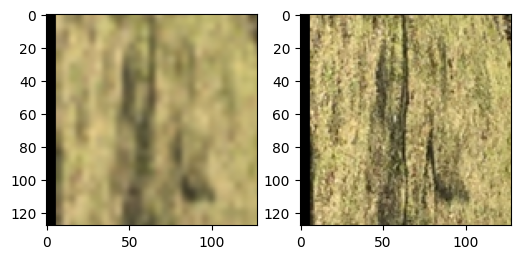

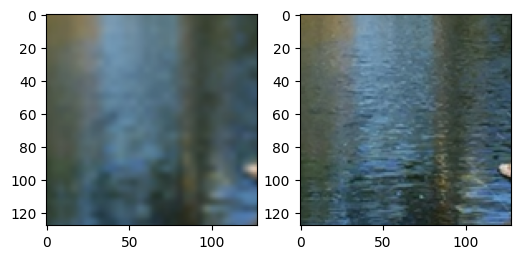

In [ ]:
UP_SCALE = 4
PATCH_SIZE = 128
BATCH_SIZE = 8

img = PIL.Image.open("alligator.jpg").resize((200,200))

sampler = DataSampler(img,
                    sr_factor=UP_SCALE,
                    crop_size=PATCH_SIZE,
                    batch_size=BATCH_SIZE)

c = 0
for batch in sampler.generate_data():
    hr, lr = batch
    _, axs = plt.subplots(1, 2, figsize=(6,4))
    for i in range(hr.shape[0]):
        axs[0].imshow(ttf.to_pil_image(lr[i,:,:,:].squeeze()))
        axs[1].imshow(ttf.to_pil_image(hr[i,:,:,:].squeeze()))
    c +=1
    if c == 4:
        break

In [ ]:
from torch.autograd import Variable
from tqdm import tqdm

def train(model, img, sr_factor=4, num_batches=100, learning_rate=0.0001,
          crop_size=64, batch_size=8):

    # Model specs initialization
    loss = torch.nn.L1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    sampler = DataSampler(img, sr_factor, crop_size, batch_size)

    model.train()
    progress_bar = tqdm(range(num_batches), total=num_batches)

    for iteration in progress_bar:
        hr, lr = sampler.generate_data().__next__()

        lr = lr.cuda()
        hr = hr.cuda()

        # Residual mapping (if not implemented by default)
        output = model(lr) # + lr
        error = loss(output, hr)

        if iteration > 0 and iteration % 1000 == 0:
            learning_rate = learning_rate / 10
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

        progress_bar.set_postfix_str(f"Iteration: {iteration}/{num_batches} lr: {learning_rate} Loss « {(error.item()):.10f} »")

        error.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Done training.")


def test(model, img, sr_factor):
    model.eval()

    img = img.resize((int(img.size[0]*sr_factor), \
        int(img.size[1]*sr_factor)), resample=PIL.Image.BICUBIC)
    #img.save('low_res.png')

    with torch.no_grad():
        img = transforms.ToTensor()(img)
        img = torch.unsqueeze(img, 0)
        input = Variable(img.to(DEVICE))
        residual = model(input)
        output = input + residual

    output = output.cpu().data[0, :, :, :]
    o = output.numpy()
    o[np.where(o < 0)] = 0.0
    o[np.where(o > 1)] = 1.0
    output = torch.from_numpy(o)
    output = transforms.ToPILImage()(output)

    return output
    #output.save('zssr.png')

In [ ]:
# Hyperparams
UP_SCALE = 4
PATCH_SIZE = 50
NUM_BATCHES = 1000
BATCH_SIZE = 32
LEARNING_RATE = 1e-6

# Load img
hr_img = PIL.Image.open("alligator.jpg").convert("RGB").resize((200,200))
lr_img = hr_img.resize((50,50))

hr = ttf.to_tensor(hr_img).unsqueeze(0)
lr = ttf.to_tensor(lr_img).unsqueeze(0)

# Model init
#model = ZSSRNet(input_channels=3, kernel_size=3, channels=64, ndepth=8).to(DEVICE)
model = MRUNet(n_channels=3, n_resblocks=1).to(DEVICE)
loss_function = torch.nn.L1Loss()

# Train
train(model, hr_img, sr_factor=UP_SCALE, num_batches=NUM_BATCHES,
      learning_rate=LEARNING_RATE, crop_size=PATCH_SIZE,
      batch_size=BATCH_SIZE)

# Inference
#output = test(model, img, sr_factor = UP_SCALE)

# bicubic interpolation
img_up = interpolate(ttf.to_tensor(img).unsqueeze(0),
                     scale_factor=UP_SCALE, mode="bicubic", antialias=True)
model.eval()
with torch.no_grad():
    inference = model(ttf.to_tensor(img).to(DEVICE))


# Eval performance
x, y = img_up, ttf.to_tensor(orig).unsqueeze(0)
print("Bicubic vs Orig:", loss_function(x,y).item(), psnr(x, y))#, ssim(x, y))
x, y = ttf.to_tensor(output).unsqueeze(0), ttf.to_tensor(orig).unsqueeze(0)
print("ZSSR vs Orig:   ", loss_function(x,y).item(), psnr(x, y))#, ssim(x, y))


# Plot
_, axs = plt.subplots(1,4,figsize=(14, 8))
axs[0].imshow(img); axs[0].set_title(f"Input at {img.size}")
axs[1].imshow(ttf.to_pil_image(img_up.squeeze())); axs[1].set_title(f"Input bicubic at {orig.size}")
axs[2].imshow(output); axs[2].set_title(f"SR(Input) at {output.size}")
axs[3].imshow(orig); axs[3].set_title(f"Original at {orig.size}")
plt.tight_layout(); plt.show()

### Custom single image train
from $(50,50)$ to $(400,400)$ simple x4 scale factor to test whether $f_{\theta}$ outperforms bicubic interpolation


In [ ]:
# Hyperparams
UP_SCALE = 4
LEARNING_RATE = 1e-5

# Load img and rescale
orig = PIL.Image.open("alligator.jpg").convert("RGB").resize((200,200))
img =  orig.resize((50,50))
orig_tensor = ttf.to_tensor(orig).unsqueeze(0)
img_tensor = ttf.to_tensor(img).unsqueeze(0)

# To device
#img_tensor = interpolate(img_tensor, scale_factor=UP_SCALE, mode="bicubic", antialias=True)
lr = img_tensor.to(DEVICE)
hr = orig_tensor.to(DEVICE)
_, _, h, w = lr.shape

# Normalise
lr = lr / lr.max()
hr = hr / hr.max()

# Model init
#model = ZSSRNet(input_channels=3, kernel_size=3, channels=64, ndepth=6).to(DEVICE)
#model = MRUNet(n_channels=3, n_resblocks=16).to(DEVICE)

# Prepare Windowsize
window_size, upscale = h, UP_SCALE
height = (h // upscale // window_size + 1) * window_size
width  = (w // upscale // window_size + 1) * window_size
print(height, width)

model = SwinIR(upscale=UP_SCALE, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 6],
                embed_dim=60, num_heads=[6, 6], mlp_ratio=2,
                upsampler='pixelshuffle').to(DEVICE)

loss_function = torch.nn.L1Loss()
optimizer     = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler     = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.1, patience=20, threshold=0.00001,
                    threshold_mode='abs')

50 50


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100%|██████████| 500/500 [03:25<00:00,  2.43it/s, Epoch: 500/500 Loss « 0.02729445 »]



Bicubic vs Orig hr: MAE 0.08249010145664215 PSNR 67.86322021484375
ZSSR lr vs Orig hr: MAE 0.027294451370835304 PSNR 75.67140197753906


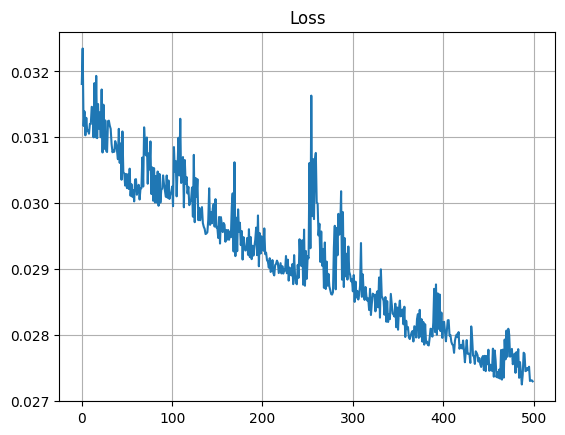

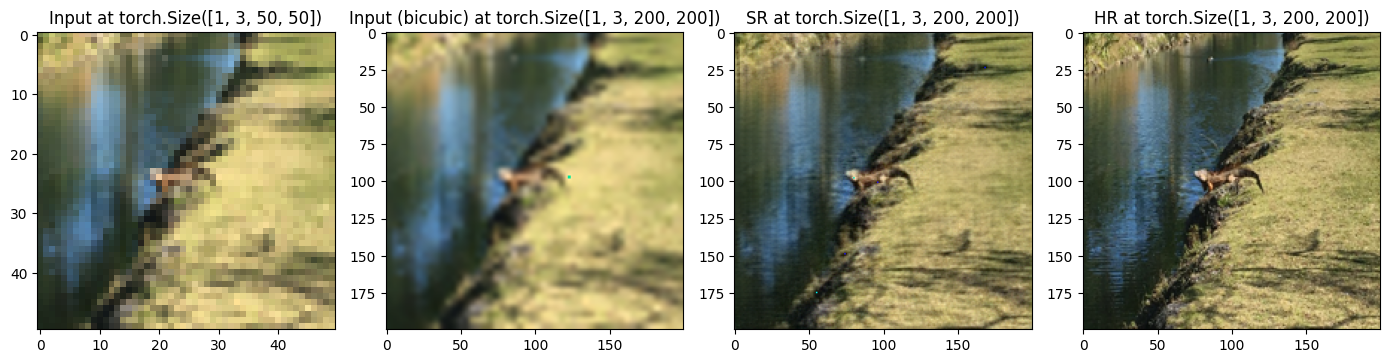

In [ ]:
NUM_EPOCHS = 500
adjust_learning_rate(optimizer, 1e-4)

# Train Loop
model.train()
progression_bar = tqdm(range(NUM_EPOCHS), total = NUM_EPOCHS)
cache = torch.zeros((NUM_EPOCHS))
for e in progression_bar:

    # MRUnet already implemented resiudual addition
    output = model(lr).to(DEVICE)
    loss = loss_function(output, hr)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #scheduler.step(loss.item())

    cache[e] = loss.item()
    progression_bar.set_postfix_str(f"Epoch: {e+1}/{NUM_EPOCHS} Loss « {(loss.item()):.8f} »")

# Performance
bicubic_lr =  interpolate(lr, scale_factor=UP_SCALE, mode="bicubic", antialias=True)
print("\nBicubic vs Orig hr:", "MAE", loss_function(bicubic_lr,hr).item(),"PSNR",psnr(bicubic_lr, hr))#, ssim(x, y))
print("ZSSR lr vs Orig hr:", "MAE", loss_function(output, hr).item(),"PSNR",psnr(output, hr))#, ssim(x, y))

#print(ssim(lr, hr), ssim(output, hr))

# Plot
plt.plot(cache); plt.title("Loss"); plt.grid(); plt.show()

_, axs = plt.subplots(1,4,figsize=(14, 8))
axs[0].imshow(ttf.to_pil_image(lr.squeeze())); axs[0].set_title(f"Input at {lr.shape}")
axs[1].imshow(ttf.to_pil_image(bicubic_lr.squeeze())); axs[1].set_title(f"Input (bicubic) at {bicubic_lr.shape}")
axs[2].imshow(ttf.to_pil_image(output.squeeze())); axs[2].set_title(f"SR at {output.shape}")
axs[3].imshow(ttf.to_pil_image(hr.squeeze())); axs[3].set_title(f"HR at {hr.shape}")
plt.tight_layout(); plt.show()

In [ ]:
#### Sliding window test to evaluate zero-shot performance vs bicubic (at least vsually)
#### try with ASTER with ground truth at x10 sf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Zero-shot super resolution by upsampling original hr to an arbitrary SF (bicubic).

In [ ]:
orig_tensor_up = interpolate(orig_tensor, scale_factor=1, mode="bilinear", antialias=True).to(DEVICE)

model.eval()
with torch.no_grad():
    zsinference = model(orig_tensor_up).to(DEVICE)

# Implement sliding windows

_,axs = plt.subplots(1,2,figsize=(12, 8))
axs[0].imshow(ttf.to_pil_image(zsinference.squeeze()))
axs[1].imshow(ttf.to_pil_image(orig_tensor_up.squeeze()))
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.24 GiB. GPU 0 has a total capacity of 14.75 GiB of which 261.06 MiB is free. Process 160375 has 14.49 GiB memory in use. Of the allocated memory 14.28 GiB is allocated by PyTorch, and 79.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)